This document is number `3 of 5` documents I have written, based on the `LangChain Academy Deep Agents with LangGraph` course.

The course itself has repositories that it provides you with. If my documents are not useful to you, I suggest you check them out.

There are now several successful examples of very **capable** and **long-running** agents. They have given these agents the 
name `“Deep Agents”` because they believe that they are completely different from previous generations of agents. In 
this course, you will learn what makes them different and build your own Deep Agent.

In LangChain, a Deep Agent is built that is simple and configurable, allowing users to build long-running agents quickly and easily.

In this course, you will build a **Deep Research Agent** using Deep Agent. The course is divided into seven modules.

Each module includes a video lesson that introduces you to the key concepts, along with related workbooks.

---

## Context Offloading with a Virtual Filesystem in LangGraph


This code shows how AI agents can become much smarter by learning to save and retrieve information, just like how you might take notes during a long study session!

### The Big Problem: Information Overload

Imagine you're working on a really long research project. After hours of gathering information, you might:
- Forget important details from earlier
- Lose track of your original question  
- Get overwhelmed by too much information at once

AI agents face the same challenge! When they work on complex tasks (like researching a topic), their "memory" (context window) gets filled up with:
- All the previous conversation
- Tool call results
- Intermediate findings
- Background information

This is called **"context accumulation"** like your desk getting messier as you work on a big project.

### The Solution: A Virtual Filing Cabinet

The solution is to teach our AI agent to use a "filing cabinet" - a virtual file system where it can:
1. **Save important information** to files instead of keeping everything in memory
2. **Read back specific information** when needed
3. **Stay organized** by listing what files it has
4. Keeps the LLM **context clean and focused**.
5. **Preserves important intermediate results** (plans, notes, data) outside the prompt window.
6. Enables sub-agents or later steps to **retrieve exact details without repeating everything**.

This is like taking organized notes during research - you write things down so you don't forget them, and you can look them up later!

Well, I said this to introduce the concept of context offloading, what it is and what it does for us.
The issues we face and solve next:
- Why context offloading matters for agents
- How a virtual filesystem works inside LangGraph state
- How to build and use file tools: `ls`, `read_file`, `write_file`
- How the agent uses these tools in a simple research task

We’ll go in the same order as your script: concept → state → tools → prompt/agent → run and inspect.

---

### 1) Imports

In [1]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent

---
### 2) Virtual Filesystem in State

**How it works**:
- `files` is a dictionary where:
  - **Keys** = file names (like "user_request.txt")
  - **Values** = file contents (the actual text)
- `file_reducer` = a function that handles saving/updating files

**Real-world analogy**: Like having a folder on your computer where:
- The folder name is the `"key"` 
- The document inside is the `"value"`


Instead of writing to the **real disk**, you’ll maintain a **“virtual filesystem”** stored in agent state:
- It’s just a dictionary: `{ "path/to/file.txt": "file content" }`
- Great for session/thread-level persistence inside a single agent run
- Not intended for cross-session persistence

You already defined the state and reducer (from your previous lesson). Recap:


In [2]:
def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence."""
    if left is None:
        return right
    elif right is None:
        return left
    else:
        # New values overwrite old ones
        return {**left, **right}

class DeepAgentState(AgentState):
    """Extended agent state with todos and a virtual filesystem."""
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

- `files` is a dict. The `file_reducer` merges updates:
  - `left` = existing files
  - `right` = new updates
  - `{**left, **right}` means keys in `right` overwrite duplicates in `left`.

**Human analogy**: When you update your notes, the new version replaces the old version.

Key idea: Tools will update `files` by returning `Command(update={...})`. The reducer ensures updates merge safely.

---



### 3) File Tools: ls, read_file, write_file

**You’ll create three tools to manage the virtual filesystem:**
- `ls()`: List files
- `read_file(file_path, offset=0, limit=2000)`: Read content with pagination (line numbers)
- `write_file(file_path, content)`: Create/overwrite a file

**Why tool descriptions in prompts?**
- You pass clear, task-oriented descriptions via `description=...` to the `@tool` decorator. The LLM sees these to know when/how to use each tool.

**Important details:**
- `InjectedState`: Lets the tool access the current graph state (the LLM does not pass it).
- `InjectedToolCallId`: Lets you create a `ToolMessage` linked to the tool call (useful for structured returns).
- Error messages should be informative for the LLM (so it can retry smartly).


**The descriptions in the prompts below describe in detail how tools operate:**

In [3]:
LS_DESCRIPTION= """
| List all files in the virtual filesystem stored in agent state.                                                 │
│                                                                                                                 │
│  Shows what files currently exist in agent memory. Use this to orient yourself before other file operations     │
│  and maintain awareness of your file organization.                                                              │
│                                                                                                                 │
│  No parameters required - simply call ls() to see all available files.                                          |
"""

READ_FILE_DESCRIPTION= """
|  Read content from a file in the virtual filesystem with optional pagination.                                   │
│                                                                                                                 │
│  This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks    │
│  to avoid context overflow.                                                                                     │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path to the file you want to read                                                      │
│  - offset (optional, default=0): Line number to start reading from                                              │
│  - limit (optional, default=2000): Maximum number of lines to read                                              │
│                                                                                                                 │
│  Essential before making any edits to understand existing content. Always read a file before editing it.        | 
"""


WRITE_FILE_DESCRIPTION= """ 
|  Create a new file or completely overwrite an existing file in the virtual filesystem.                          │
│                                                                                                                 │
│  This tool creates new files or replaces entire file contents. Use for initial file creation or complete        │
│  rewrites. Files are stored persistently in agent state.                                                        │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path where the file should be created/overwritten                                      │
│  - content (required): The complete content to write to the file                                                │
│                                                                                                                 │
│  Important: This replaces the entire file content. Use edit_file for partial modifications.                     |
"""

**Code:**

In [4]:
@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())

@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    # Include line numbers, truncate very long lines
    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    return "\n".join(result_lines)

@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object 


#### Tool 1: `ls` (List Files)

**What it does**: Shows all the files the agent has saved

**Human equivalent**: Looking at your folder to see what notes you've taken

#### Tool 2: `read_file` (Read a File)

**What it does**: 
- Reads the contents of a specific file
- Can read just part of a file (using `offset` and `limit`) to avoid information overload
- Adds line numbers for easy reference

**Human equivalent**: Opening a specific notebook and reading your notes

#### Tool 3: `write_file` (Save Information)

**What it does**: 
- Creates a new file or completely replaces an existing one
- Saves information permanently (for this conversation)
- Returns a confirmation message

**Human equivalent**: Writing notes in your notebook

**Notes:**
- `read_file` supports pagination (`offset`, `limit`) and line-numbering. This prevents dumping huge files into context at once.
- `write_file` returns a `Command` that updates state and appends a `ToolMessage` so the LLM sees the operation outcome.
- `ls` is simple: just list the keys of `files`.

---

### 4) Prompting the Agent to Use Files

You craft instructions that teach the agent a workflow:
1. Orient: check existing files with `ls()`
2. Save: store the user’s request with `write_file()`
3. Read: read back the saved file with `read_file()` to answer precisely

Plus a simple research rule: “Only use `web_search` once and base your answer on it.”


In [5]:
FILE_USAGE_INSTRUCTIONS = """You MUST follow this exact workflow for every user request:

1. **ALWAYS start by calling ls()** to check existing files
2. **ALWAYS call write_file()** to save the user's request to "user_request.txt" 
3. **THEN call web_search()** exactly once to gather information
4. **ALWAYS call read_file()** to re-read the saved user request
5. **ONLY THEN provide your final answer** based on the research and saved request

DO NOT skip any steps. DO NOT take shortcuts. This workflow is mandatory.
"""

SIMPLE_RESEARCH_INSTRUCTIONS = """After completing the required file workflow above, use web_search exactly once and base your answer on both the search results and the saved user request."""

ENFORCEMENT = """
CRITICAL: You will be marked as FAILED if you:
- Skip calling ls() first
- Skip saving the user request with write_file()  
- Skip reading back the request with read_file()
- Use web_search without following the file workflow

SUCCESS means: ls() → write_file() → web_search() → read_file() → final answer
"""

INSTRUCTIONS = FILE_USAGE_INSTRUCTIONS + "\n\n" + ENFORCEMENT + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS

This is `“prompt engineering”` for tool usage: clear, step-by-step expectations reduce confusion and improve reliability.

**Important note:** I changed the two prompts `"FILE_USAGE_INSTRUCTIONS"` and `"SIMPLE_RESEARCH_INSTRUCTIONS"` and also added another prompt called 
`"ENFORCEMENT"`. 
The reason for this was that when I ran the agent with the two initial prompts of the academy, the agent did not use the 
`read_file`, `write_file`, and `ls` tools, which means there was no `Context Offloading`. That's why I decided to change the prompts related to the 
agent workflow.

---


### 5) Building the Agent with create_react_agent

**You create:**
- A mock `web_search` tool (returns a canned MCP summary)
- The agent with your tools and prompt
- `DeepAgentState` as the state schema

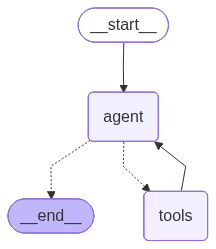

In [ ]:
# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """

@tool(parse_docstring=True)
def web_search(query: str):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result

model = init_chat_model(model="openai:gpt-4o-mini", api_key="sk-proj-***", temperature=0.0)
tools = [ls, read_file, write_file, web_search]

agent = create_react_agent(
    model, tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


What `create_react_agent` does:
- Builds a ReAct loop: LLM step → tool execution → observe → repeat until done
- Manages the `messages` and your `files` state
- Executes multiple tool calls in one step if the LLM requests them

---


### 6) Running the Agent (Step-by-Step Behavior)

You invoke the agent with:
- A user message: “Give me an overview of Model Context Protocol (MCP).”
- Initial empty files: `{}`

In [7]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
        "files": {},
    }
)

**Typical flow observed in your sample output:**
1. AI calls `ls` to see current files (none).
2. AI calls `write_file` to save the user request into `user_request.txt`.
3. AI calls `web_search` once to fetch info.
4. AI calls `read_file` to read back the saved request (to stay aligned with the user’s ask).
5. AI composes the final answer using the search result, tailored to the saved prompt.

**Why this is good:**
- The agent “remembers” the exact user request in a file.
- Even if the conversation grows, it can re-load the anchor requirements using `read_file`.
- This mirrors production patterns where sub-agents spawn, read the shared plan, do focused work, and write artifacts or notes back to files.

Inspecting the final state:

In [ ]:
# Before creating agent, verify your tools
print("Available tools:", [tool.name for tool in tools])
print("Instructions preview:", INSTRUCTIONS[:200] + "...")

# After running, check the trace
def detailed_trace(result):
    print("=== TOOL CALLS MADE ===")
    for i, msg in enumerate(result["messages"]):
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            for call in msg.tool_calls:
                print(f"Step {i}: {call['name']} with {call['args']}")
    
    print("\n=== FILES CREATED ===")
    print(result.get("files", {}))

detailed_trace(result)

Available tools: ['ls', 'read_file', 'write_file', 'web_search']
Instructions preview: You MUST follow this exact workflow for every user request:

1. **ALWAYS start by calling ls()** to check existing files
2. **ALWAYS call write_file()** to save the user's request to "user_request.txt...
=== TOOL CALLS MADE ===
Step 1: ls with {}
Step 3: write_file with {'file_path': 'user_request.txt', 'content': 'Give me an overview of Model Context Protocol (MCP).'}
Step 5: web_search with {'query': 'Model Context Protocol (MCP) overview'}
Step 7: read_file with {'file_path': 'user_request.txt'}

=== FILES CREATED ===
{'user_request.txt': 'Give me an overview of Model Context Protocol (MCP).'}


In [9]:
from langchain_core.messages import HumanMessage, ToolMessage, AIMessage

def print_agent_trace(messages):
    """
    Print a detailed step-by-step trace of the agent's reasoning, tool calls, and tool outputs,
    showing the full "graph" of the agent's process.
    """
    for i, message in enumerate(messages):
        prefix = f"[{i+1:02d}]"
        # Human input
        if isinstance(message, HumanMessage):
            print(f"{prefix} 🧑 Human:")
            print(f"    {message.content}\n")
        # AI message (may include tool calls)
        elif hasattr(message, "tool_calls") and getattr(message, "tool_calls"):
            print(f"{prefix} 🤖 AI (Tool Calls):")
            for j, call in enumerate(message.tool_calls):
                name = call.get("name", "<unknown>")
                args = call.get("args", {})
                print(f"    ├─🔧 Tool Call [{j+1}]: {name}")
                print(f"    │     Args: {args}")
            print()
        # Tool output
        elif isinstance(message, ToolMessage):
            print(f"{prefix} 🛠️ Tool Output:")
            print(f"    Tool: {getattr(message, 'tool_call_id', '<unknown>')}")
            print(f"    Output: {message.content}\n")
        # AI message (final answer or intermediate reasoning)
        elif isinstance(message, AIMessage):
            print(f"{prefix} 🤖 AI (Final/Intermediate):")
            print(f"    {message.content}\n")
        # Fallback for any other message type
        else:
            content = getattr(message, "content", "")
            if content:
                print(f"{prefix} 🤖 AI (Other):")
                print(f"    {content}\n")

print_agent_trace(result["messages"])


[01] 🧑 Human:
    Give me an overview of Model Context Protocol (MCP).

[02] 🤖 AI (Tool Calls):
    ├─🔧 Tool Call [1]: ls
    │     Args: {}

[03] 🛠️ Tool Output:
    Tool: call_WxvKBI3oO0MqBA6fSHo9RVDF
    Output: []

[04] 🤖 AI (Tool Calls):
    ├─🔧 Tool Call [1]: write_file
    │     Args: {'file_path': 'user_request.txt', 'content': 'Give me an overview of Model Context Protocol (MCP).'}

[05] 🛠️ Tool Output:
    Tool: call_fQR7PBh6hGllkISGo6rbaHrR
    Output: Updated file user_request.txt

[06] 🤖 AI (Tool Calls):
    ├─🔧 Tool Call [1]: web_search
    │     Args: {'query': 'Model Context Protocol (MCP) overview'}

[07] 🛠️ Tool Output:
    Tool: call_V5oyZFIKGA9eCJXMALz2ikJD
    Output: The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from var

In [10]:
result["files"]

{'user_request.txt': 'Give me an overview of Model Context Protocol (MCP).'}


### The Workflow Strategy


#### Step-by-Step Example:

Let's trace through what happens when a user asks: *"Give me an overview of Model Context Protocol (MCP)."*

#### Step 1: Check What Files Exist
```
Agent calls: ls()
Result: [] (empty list - no files yet)
```

#### Step 2: Save the User's Request
```
Agent calls: write_file("user_request.txt", "User Request: Give me an overview of Model Context Protocol...")
Result: "Updated file user_request.txt"
```

**Why this is smart**: The agent saves the original question so it won't forget what the user actually asked for, even after doing lots of research.

#### Step 3: Do Research
```
Agent calls: web_search("Model Context Protocol MCP overview...")
Result: [Information about MCP]
```

#### Step 4: Re-read Original Request
```
Agent calls: read_file("user_request.txt")
Result: Shows the original user request with line numbers
```

**Why this is brilliant**: Before answering, the agent checks its notes to make sure it answers exactly what the user asked for!

#### Step 5: Provide Comprehensive Answer
The agent now has:
- The original question (from its file)
- Research results (from web search)
- Clear focus on what to answer

---

### 8) Mental Model: What’s Happening Under the Hood

- The agent’s state has:
  - `messages`: conversation + tool outputs
  - `files`: your virtual filesystem
- Tools are standard Python functions decorated with `@tool`. The LLM can call them by name with arguments.
- `InjectedState` gives tools access to state without exposing it to the LLM prompt.
- `Command(update=...)` lets tools update multiple parts of state atomically (e.g., write file + add a ToolMessage).
- The ReAct loop continues until the LLM stops requesting tools and returns a final answer.

---